This notebook examines correlations between sky factors (moon distance, moon illumination, seeing, and zero-point magnitude) and the number of "good" (R/B > 0.6) object detections per exposure.

In [1]:
import psycopg2
import psycopg2.extras
import getpass
from IPython.display import display
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.time import Time
from astropy.coordinates import get_moon, GCRS
import astropy.units as u
import matplotlib as mpl

In [2]:
font = {'size'   : 13}

mpl.rc('font', **font)

In [3]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")

DB User:  kennedyt
DB Password:  ············


In [4]:
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")

In [5]:
db.autocommit = True # Makes the computer more forgiving about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

#### How does the distance to the moon affect the number of good detections? (COSMOS)

In [6]:
query = ( 'SELECT o.id, e.filename, e.mjd, e.ra, e.dec, e.filter FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'AND o.rb>0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

moonquery = np.array( cursor.fetchall() ).transpose()

In [7]:
# Counting the number of objects in each exposure (objs) and masking the dates, filters, and coordinates to match
exps, indices, objs = np.unique( moonquery[1], return_counts=True, return_index=True )
mjds = moonquery[2][indices].astype(np.float)
filters = moonquery[5][indices]
obs_coords = GCRS( ra = moonquery[3][indices].astype(np.float)*u.deg, dec = moonquery[4][indices].astype(np.float)*u.deg, representation_type=None )

# Putting it into a Pandas DataFrame to keep better track of what is what
moon_df = pd.DataFrame(np.array([exps,objs,filters,mjds, obs_coords]).transpose(), columns = ['Fnm', 'Objs', 'Filter', 'MJD', 'ObsCoords'])

In [8]:
# Calculate the Moon's coordinates at the time of observation and put them into a new column
moon_df['MJD'] = [Time(i, format='mjd') for i in moon_df['MJD']]
moon_df["MoonCoords"] = [get_moon(i) for i in moon_df['MJD']]

In [9]:
# Calculate the great circle distance separation between the observation and the Moon and put it in a new column
moon_df['MoonSep'] = [moon_df['ObsCoords'][i].separation(moon_df['MoonCoords'][i]) for i in range(len(moon_df['Fnm']))]
moon_df['MoonSep'] = [i.value for i in moon_df['MoonSep']]

In [10]:
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)
fnms = [exps[i][:21] for i in range(len(exps))] # truncate filenames to match lookup table format

In [11]:
# find the exposure time for each object
moon_df["Exptime"] = np.array([exptable[np.where(fnms[i] == fnmtable)[0]][0] for i in range(len(fnms))], dtype=float)

In [12]:
# Eliminate objects from non-standard images
gmsk = np.where((moon_df["Filter"]=="g") & (moon_df["Exptime"]>50))[0]
rmsk = np.where((moon_df["Filter"]=="r") & (moon_df["Exptime"]>20))[0]
imsk = np.where((moon_df["Filter"]=="i") & (moon_df["Exptime"]>20))[0]
grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)
len(grimsk)
# apply the standard images mask
for i in moon_df:
    moon_df[i] = moon_df[i][grimsk]

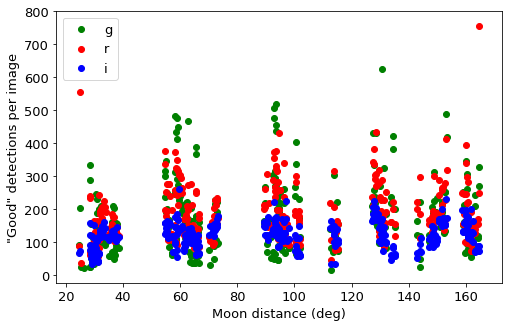

In [13]:
# Create masks for different filters
gmsk = np.where(moon_df["Filter"]=='g')[0]
rmsk = np.where(moon_df["Filter"]=='r')[0]
imsk = np.where(moon_df["Filter"]=='i')[0]

# Plot
plt.figure(figsize=(8,5))
plt.scatter(moon_df['MoonSep'][gmsk], moon_df['Objs'][gmsk], color='g', label='g')
plt.scatter(moon_df['MoonSep'][rmsk], moon_df['Objs'][rmsk], color='r', label='r')
plt.scatter(moon_df['MoonSep'][imsk], moon_df['Objs'][imsk], color='b', label='i')
plt.xlabel('Moon distance (deg)')
plt.ylabel('"Good" detections per image')
plt.legend()
plt.savefig("./images/moondistVopi_COSMOS");

#### How does the distance to the moon affect the number of good detections? (COSMOS) (This section uses the 'moondata.txt' lookup table but gets the same result as above, so I have it commented out)

In [18]:
# query = ( 'SELECT o.candidate_id, e.filename, e.filter FROM objects o '
#          'JOIN subtractions s ON o.subtraction_id=s.id '
#          'JOIN exposures e ON e.id=s.exposure_id '
#          'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
#          'AND o.rb>0.6 '
#          'LIMIT 10000000' )

# cursor.execute( query )

# moonquery2 = np.array( cursor.fetchall() ).transpose()

In [19]:
# fnms = [moonquery2[1][i][:21] for i in range(len(moonquery2[1]))] # truncate filenames to match lookup table format
# cands, index, objsperimg = np.unique(moonquery2[1], return_index=True, return_counts=True)
# table = np.loadtxt("moondata.txt", dtype=np.str).transpose()
# fnms = np.array(fnms)[index]
# moondist = np.ones(len(fnms))
# for i in range(len(fnms)):
#     moondist[i] = table[1][np.where(fnms[i] == table[0])[0]]

In [20]:
# # Create masks for different filters
# gmsk = np.where(moonquery2[2][index]=='g')[0]
# rmsk = np.where(moonquery2[2][index]=='r')[0]
# imsk = np.where(moonquery2[2][index]=='i')[0]

In [21]:
# # Plotting it all up, looks the same as before

# plt.figure(figsize=(8,5))
# plt.scatter(moondist[gmsk], objsperimg[gmsk], color='g', label='g')
# plt.scatter(moondist[rmsk], objsperimg[rmsk], color='r', label='r')
# plt.scatter(moondist[imsk], objsperimg[imsk], color='b', label='i')
# plt.xlabel('Moon distance (deg)')
# plt.ylabel('"Good" detections per image')
# plt.legend();

#### How does moon illumination affect the number of good detections per image? (uses lookup table 'moondata.txt')

In [14]:
query = ( 'SELECT o.candidate_id, e.filename, e.filter FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'AND o.rb>0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

moonquery2 = np.array( cursor.fetchall() ).transpose()

In [15]:
# truncate filenames to match lookup table format
fnms = [ moonquery2[1][i][:21] for i in range( len( moonquery2[1] ) ) ]

# count the number of objects in each image (obsperimg) and create a mask to select the data for each of those exposures only once (index)
cands, index, objsperimg = np.unique( moonquery2[1], return_index=True, return_counts=True )

# load in the lookup table
moonlt = np.loadtxt( "moondata.txt", dtype=np.str ).transpose()

fnms = np.array( fnms )[index]

# create an array of moon illuminations by matching the filenames in the query result to the filenames in the lookup table
illum = np.ones( len( fnms ) )
for i in range( len( fnms ) ):
    illum[i] = moonlt[2][ np.where( fnms[i] == moonlt[0] )[0] ]

In [16]:
# read in the exposure time lookup table
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)

# find the exposure time for each object
exptimes = np.array([exptable[np.where(fnms[i] == fnmtable)[0]][0] for i in range(len(fnms))], dtype=float)

In [17]:
# Eliminate objects from non-standard images
filters = np.array( moonquery2[2] )[index]

gmsk = np.where((filters=="g") & (exptimes>50))[0]
rmsk = np.where((filters=="r") & (exptimes>20))[0]
imsk = np.where((filters=="i") & (exptimes>20))[0]

grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

# apply the standard images mask
filters = filters[grimsk]
illum = illum[grimsk]
objsperimg = objsperimg[grimsk]

In [18]:
# Create masks for different filters
gmsk = np.where( filters=='g' )[0]
rmsk = np.where( filters=='r' )[0]
imsk = np.where( filters=='i' )[0]

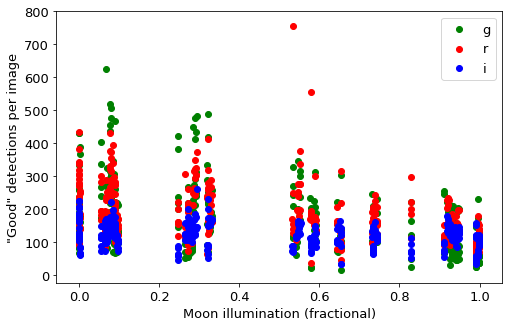

In [19]:
# Plotting it

plt.figure( figsize=(8,5) )
plt.scatter( illum[gmsk], objsperimg[gmsk], color='g', label='g' )
plt.scatter( illum[rmsk], objsperimg[rmsk], color='r', label='r' )
plt.scatter( illum[imsk], objsperimg[imsk], color='b', label='i' )
plt.xlabel( 'Moon illumination (fractional)' )
plt.ylabel( '"Good" detections per image' )
plt.legend()
plt.savefig("./images/moonillVopi_COSMOS");

#### How does median pixel value affect number of good detections? (uses lookup table 'medpixval.txt')

In [20]:
query = ( 'SELECT o.candidate_id, e.filename, e.filter FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'AND o.rb>0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

pixvalquery = np.array( cursor.fetchall() ).transpose()

In [21]:
# truncate filenames to match lookup table format
fnms = [pixvalquery[1][i][:21] for i in range(len(pixvalquery[1]))]

# count the number of objects in each image (obsperimg) and create a mask to select the data for each of those exposures only once (index)
cands, index, objsperimg = np.unique(pixvalquery[1], return_index=True, return_counts=True)

# load in the lookup table
pixvallt = np.loadtxt("medpixval.txt", dtype=np.str).transpose()

# resize the filename array to only look at each exposure once (i.e. not once for every object in it)
fnms = np.array(fnms)[index]

# create an array of mmedian pixel values by matching the filenames in the query result to the filenames in the lookup table 
pixval = np.ones(len(fnms))
for i in range(len(fnms)):
    pixval[i] = pixvallt[1][np.where(fnms[i] == pixvallt[0])[0]]

In [22]:
# read in the exposure time lookup table
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)

# find the exposure time for each object
exptimes = np.array([exptable[np.where(fnms[i] == fnmtable)[0]][0] for i in range(len(fnms))], dtype=float)

In [23]:
# Eliminate objects from non-standard images
filters = np.array( pixvalquery[2] )[index]

gmsk = np.where((filters=="g") & (exptimes>50))[0]
rmsk = np.where((filters=="r") & (exptimes>20))[0]
imsk = np.where((filters=="i") & (exptimes>20))[0]

grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

# apply the standard images mask
filters = filters[grimsk]
pixval = pixval[grimsk]
objsperimg = objsperimg[grimsk]

In [24]:
# Create masks for different filters
gmsk = np.where(filters=='g')[0]
rmsk = np.where(filters=='r')[0]
imsk = np.where(filters=='i')[0]

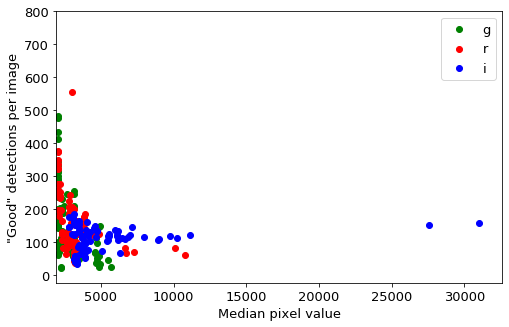

In [25]:
# Plotting it up
plt.figure(figsize=(8,5))
plt.scatter(pixval[gmsk], objsperimg[gmsk], color='g', label='g')
plt.scatter(pixval[rmsk], objsperimg[rmsk], color='r', label='r')
plt.scatter(pixval[imsk], objsperimg[imsk], color='b', label='i')
plt.xlim(1920, )
plt.xlabel('Median pixel value')
plt.ylabel('"Good" detections per image')
plt.legend()
plt.savefig("./images/medpixvalVopi_COSMOS");

#### How does seeing affect the number of good detections? (COSMOS)

In [26]:
query = ( 'SELECT o.id, e.filename, s.seeing, e.filter, e.id FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'AND o.rb>0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

seeingquery = np.array( cursor.fetchall() ).transpose()

In [27]:
expids = seeingquery[4].astype(np.int)
seeing = seeingquery[2].astype(np.float)

# Determine which exposure IDs are present
# expids_unique = np.unique(expids)
expids_unique, indices, objperimg = np.unique( seeingquery[4], return_counts=True, return_index=True )


# Find the average seeing for each exposure
seeing = np.array( [np.mean( seeing[np.where( expids == i )[0]] ) for i in expids_unique.astype(float)] )

In [28]:
# determine how many objects are in each exposure, and create an array of filters resized in the same way
exp, indices, objperimg = np.unique( seeingquery[4], return_counts=True, return_index=True )
filters = np.array(seeingquery[3][indices])
fnms = seeingquery[1][indices]

In [29]:
# truncate filenames to match lookup table format
fnms = [fnms[i][:21] for i in range(len(fnms))]

# read in the exposure time lookup table
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)

# find the exposure time for each object
exptimes = np.array([exptable[np.where(fnms[i] == fnmtable)[0]][0] for i in range(len(fnms))], dtype=float)

In [30]:
# Eliminate objects from non-standard images
gmsk = np.where((filters=="g") & (exptimes>50))[0]
rmsk = np.where((filters=="r") & (exptimes>20))[0]
imsk = np.where((filters=="i") & (exptimes>20))[0]

grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

# apply the standard images mask
seeing = seeing[grimsk]
objperimg = objperimg[grimsk]
filters = filters[grimsk]
len(grimsk)

1038

In [31]:
# Creating masks for each filter
gmsk = np.where( filters == 'g' )[0]
rmsk = np.where( filters == 'r' )[0]
imsk = np.where( filters == 'i' )[0]

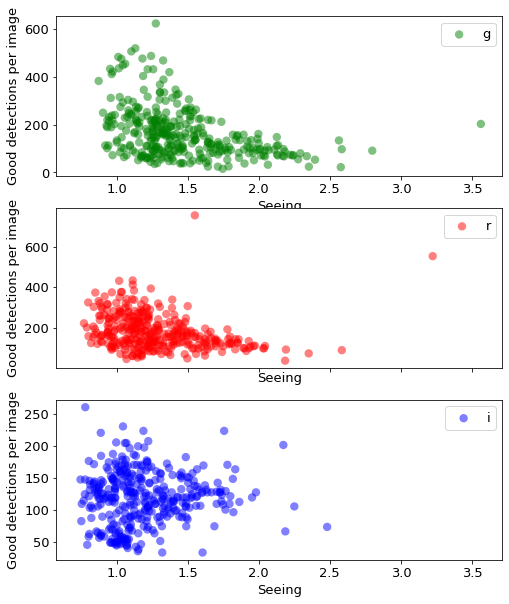

In [33]:
# Plotting it all up
fig, ax = plt.subplots(3, figsize=(8,10), sharex=True)
ax[0].xaxis.set_tick_params(which='both', labelbottom=True)

# plt.scatter( seeing[rmsk], objperimg[rmsk], color='r', label='r', s=70, alpha=0.5, edgecolors='none')

ax[0].scatter( seeing[gmsk], objperimg[gmsk], color='g', label='g', s=70, alpha=0.5, edgecolors='none')
ax[1].scatter( seeing[rmsk], objperimg[rmsk], color='r', label='r', s=70, alpha=0.5, edgecolors='none')
ax[2].scatter( seeing[imsk], objperimg[imsk], color='b', label='i', s=70, alpha=0.5, edgecolors='none')
ax[0].set_xlabel( 'Seeing' )
ax[0].set_ylabel( 'Good detections per image' )
ax[0].legend()
ax[1].set_xlabel( 'Seeing' )
ax[1].set_ylabel( 'Good detections per image' )
ax[1].legend()
ax[2].set_xlabel( 'Seeing' )
ax[2].set_ylabel( 'Good detections per image' )
ax[2].legend()
plt.savefig("./images/seeingVopi_COSMOS");

#### How does magzp affect number of good detections? (COSMOS)

In [34]:
query = ( 'SELECT o.id, e.filename, s.magzp, e.filter, e.id, e.mjd FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'AND o.rb>0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

magzpquery = np.array( cursor.fetchall() ).transpose()

In [35]:
fnms = np.array(magzpquery[1], dtype=str)
magzp = magzpquery[2].astype(np.float)

# Determine which exposure IDs are present
# expids_unique = np.unique(expids)
fnms_unique, indices, objperimg = np.unique( fnms, return_counts=True, return_index=True )
fnms_unique = fnms_unique.astype(str)
# Find the average magzp for each exposure
magzpav = np.zeros(len(fnms_unique))
for i in range(len(fnms_unique)):
    msk = np.where( fnms == fnms_unique[i] )[0]
    magzpav[i] = np.median( magzp[msk] )

# magzp = np.array( [np.median( magzp[np.where( fnms == i )[0]] ) for i in fnms_unique.astype(str)] )

In [36]:
len(magzp)

166483

In [37]:
# determine how many objects are in each exposure, and create an array of filters resized in the same way
# exp, indices, objperimg = np.unique( expids, return_counts=True, return_index=True )
filters = magzpquery[3][indices]

In [38]:
# truncate filenames to match lookup table format
fnms_unique = [fnms_unique[i][:21] for i in range(len(fnms_unique))]

# read in the exposure time lookup table
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)

# find the exposure time for each object
exptimes = np.array([exptable[np.where(fnms_unique[i] == fnmtable)[0]][0] for i in range(len(fnms_unique))], dtype=float)

In [39]:
# Eliminate objects from non-standard images
gmsk = np.where((filters=="g") & (exptimes>50))[0]
rmsk = np.where((filters=="r") & (exptimes>20))[0]
imsk = np.where((filters=="i") & (exptimes>20))[0]

grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

# apply the standard images mask
magzpav = magzpav[grimsk]
objperimg = objperimg[grimsk]
filters = filters[grimsk]

In [40]:
len(exptimes)

1117

In [41]:
# Creating masks for each filter
gmsk = np.where( filters == 'g' )[0]
rmsk = np.where( filters == 'r' )[0]
imsk = np.where( filters == 'i' )[0]

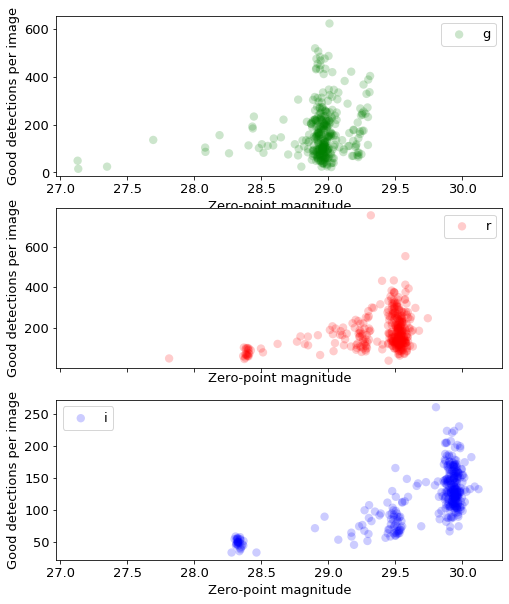

In [44]:
# Plotting it all up
fig, ax = plt.subplots(3, figsize=(8,10), sharex=True)
ax[0].xaxis.set_tick_params(which='both', labelbottom=True)

ax[0].scatter( magzpav[gmsk], objperimg[gmsk], color='g', label='g', s=70, alpha=0.2, edgecolors='none')
ax[1].scatter( magzpav[rmsk], objperimg[rmsk], color='r', label='r', s=70, alpha=0.2, edgecolors='none')
ax[2].scatter( magzpav[imsk], objperimg[imsk], color='b', label='i', s=70, alpha=0.2, edgecolors='none')
ax[0].set_xlabel( 'Zero-point magnitude' )
ax[0].set_ylabel( 'Good detections per image' )
ax[0].legend()
ax[1].set_xlabel( 'Zero-point magnitude' )
ax[1].set_ylabel( 'Good detections per image' )
ax[1].legend()
ax[2].set_xlabel( 'Zero-point magnitude' )
ax[2].set_ylabel( 'Good detections per image' )
ax[2].legend()
plt.savefig("./images/magzpVopi_COSMOS");